# Exercise 5 - ConvNet

## Exercise 5a
What loss function would be most suitable to train this network, and what underlying assumption have you made by choosing this loss function?

The mean squared error (MSE) loss would be a suitable loss function to train this network. By choosing the MSE loss, we assume that the noise in the input k-space data is independent and identically distributed Gaussian noise. 

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

from Fast_MRI_dataloader import create_dataloaders
from tqdm import tqdm 
import matplotlib.pyplot as plt
from torch.fft import ifft2
import numpy as np

## Exercise 5b

In [33]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # create layers here
        self.conv = nn.Sequential(
            # input is N, 1, 320, 320
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5, 5), stride=1, padding=2), # N, 16, 320, 320
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), stride=1, padding=2), # N, 16, 320, 320
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), stride=1, padding=2), # N, 16, 320, 320
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(5, 5), stride=1, padding=2), # N, 1, 320, 320
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
       

    def forward(self, x):
        return self.conv(x)
    

In [34]:
# calculate validation loss
def calculate_loss(model, data_loader, criterion, device):
    """
    Calculate the loss on the given data set.
    -------
    model : model class
        Model structure to fit, as defined by build_model().
    data_loader : torch.utils.data.DataLoader
        Data loader to use for the data set.
    criterion : torch.nn.modules.loss
        Loss function to use.
    device : torch.device
        Device to use for the model.
    -------
    loss : float    
        The loss on the data set.
    """
    # set model to evaluation mode
    model.eval()

    # initialize loss
    loss = 0

    # loop over batches
    # go over all minibatches
    for i, (partial_kspace, M, gt) in enumerate(tqdm(data_loader)):
        
        # get accelerated MRI image from partial k-space
        acc_mri = torch.abs(ifft2(partial_kspace))

        # unsqueeze to add channel dimension, (N, 320, 320) -> (N, 1, 320, 320)
        gt_unsqueeze = torch.unsqueeze(gt, dim=1)
        acc_mri = torch.unsqueeze(acc_mri, dim=1)

        if torch.cuda.is_available():
            device = torch.device('cuda:0')
            gt_unsqueeze, acc_mri = [x.cuda() for x in [gt_unsqueeze, acc_mri]]
            model.to(device)

        # forward pass
        x_out = model(acc_mri)
        
        # calculate loss
        loss += criterion(x_out, gt_unsqueeze).item()

    # return the loss
    return loss

# train model function
def train_model(model, train_loader, valid_loader, optimizer, criterion, n_epochs, device, write_to_file=True, save_path=None):
    """
    Fit the model on the training data set.
    Arguments
    ---------
    model : model class
        Model structure to fit, as defined by build_model().
    train_loader : torch.utils.data.DataLoader
        Dataloader for the training set.
    valid_loader : torch.utils.data.DataLoader
        Dataloader for the validation set.
    optimizer : torch.optim.Optimizer
        Optimizer to use for training.
    criterion : torch.nn.modules.loss
        Loss function to use for training.
    epochs : int
        Number of epochs to train for.
    device : torch.device
        Device to use for training.
    write_to_file : bool
        Whether to write the model parameters to a file.
    path_to_save_model : str
        Path to save the model parameters to.

    Returns
    -------
    model : model class
        The trained model.
    training_losses : list
        The training loss for each epoch.
    validation_losses : list
        The validation loss for each epoch.
    """
    # to keep track of loss
    train_losses = []
    valid_losses = []

    # define LR scheduler
    scheduler = ExponentialLR(optimizer, gamma=0.95)

    # go over all epochs
    for epoch in range(n_epochs):
        print(f"\nTraining Epoch {epoch}:")
        
        train_loss = 0
        valid_loss = 0

        # go over all minibatches
        for i,(kspace, M, gt) in enumerate(tqdm(train_loader)):

            # copmute min max of gt
            gt_min = torch.min(gt)
            gt_max = torch.max(gt)
            
            # unsqueeze to add channel dimension, (N, 320, 320) -> (N, 1, 320, 320)
            gt_unsqueeze = torch.unsqueeze(gt,dim =1)
            kspace_unsqueeze = torch.unsqueeze(kspace,dim =1)

            # get accelerated MRI image from partial k-space
            acc_mri = ifft2(kspace_unsqueeze)
            acc_mri = torch.abs(acc_mri)

            # move to device
            gt_unsqueeze = gt_unsqueeze.to(device)
            acc_mri = acc_mri.to(device)
            model = model.to(device)

            # forward pass
            x_out = model(acc_mri)
            loss = criterion(x_out, gt_unsqueeze) 
        
            # backward pass, update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # add loss to the total loss
            train_loss += loss.item()

        # calculate validation loss
        valid_loss = calculate_loss(model, valid_loader, criterion, device) # autoencoder 
        valid_loss_average = valid_loss / len(valid_loader)

        # average loss for this epoch = train_loss / n_batches
        train_loss /= len(train_loader)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss_average)
        print(f"Average train loss for epoch {epoch} is {train_loss}, validation loss is {valid_loss_average}")

        # write the model parameters to a file every 5 epochs
        if write_to_file and epoch % 5 == 0:
            torch.save(model.state_dict(), f"{save_path}CNN_{epoch}_epochs.pth")

        # update the learning rate
        scheduler.step()
        # print the new learning rate
        print(f"Learning rate is {scheduler.get_last_lr()}")

    if write_to_file:
        torch.save(model.state_dict(), f"{save_path}CNN_{epoch}_epochs.pth")

    # return the trained model
    return model, train_losses, valid_losses

def plot_loss(train_losses, test_losses, save_path):
    """
    Plots the loss.
    -------
    train_losses: list
        The training loss
    valid_losses: list
        The validation loss
    """
    num_epochs = len(train_losses)

    # plot the loss
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_losses, label='Training loss')
    ax.plot(test_losses, label='Testing loss')
    ax.set_xlim(0, num_epochs-1)

    # axis labels
    plt.xlabel('Epoch[n]', fontsize="x-large")
    plt.ylabel('Loss', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.grid(True)
    plt.xticks(np.arange(0, num_epochs, 2))
    plt.savefig(f"{save_path}", dpi=300, bbox_inches='tight')
    plt.show()


Training Epoch 0:


100%|██████████| 31/31 [00:14<00:00,  2.17it/s]


Average train loss for epoch 0 is 0.0465385995884525, validation loss is 0.02220569076316972
Learning rate is [0.00095]

Training Epoch 1:


100%|██████████| 31/31 [00:13<00:00,  2.25it/s]


Average train loss for epoch 1 is 0.019132424968274983, validation loss is 0.014477437211861533
Learning rate is [0.0009025]

Training Epoch 2:


100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


Average train loss for epoch 2 is 0.017647754153276376, validation loss is 0.014122231412799127
Learning rate is [0.000857375]

Training Epoch 3:


100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Average train loss for epoch 3 is 0.017263427069608834, validation loss is 0.013699060876763636
Learning rate is [0.0008145062499999999]

Training Epoch 4:


100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Average train loss for epoch 4 is 0.016877479960230438, validation loss is 0.013532574799272322
Learning rate is [0.0007737809374999998]

Training Epoch 5:


100%|██████████| 31/31 [00:14<00:00,  2.17it/s]


Average train loss for epoch 5 is 0.016576764540390133, validation loss is 0.013184385554444405
Learning rate is [0.0007350918906249997]

Training Epoch 6:


100%|██████████| 31/31 [00:13<00:00,  2.24it/s]


Average train loss for epoch 6 is 0.0163707652505725, validation loss is 0.012992636330666081
Learning rate is [0.0006983372960937497]

Training Epoch 7:


100%|██████████| 31/31 [00:14<00:00,  2.13it/s]


Average train loss for epoch 7 is 0.016292583900801044, validation loss is 0.013046763687124175
Learning rate is [0.0006634204312890621]

Training Epoch 8:


100%|██████████| 31/31 [00:13<00:00,  2.22it/s]


Average train loss for epoch 8 is 0.016167527015142617, validation loss is 0.01290593849074456
Learning rate is [0.000630249409724609]

Training Epoch 9:


100%|██████████| 31/31 [00:13<00:00,  2.23it/s]


Average train loss for epoch 9 is 0.016107542291679915, validation loss is 0.01278745157704238
Learning rate is [0.0005987369392383785]


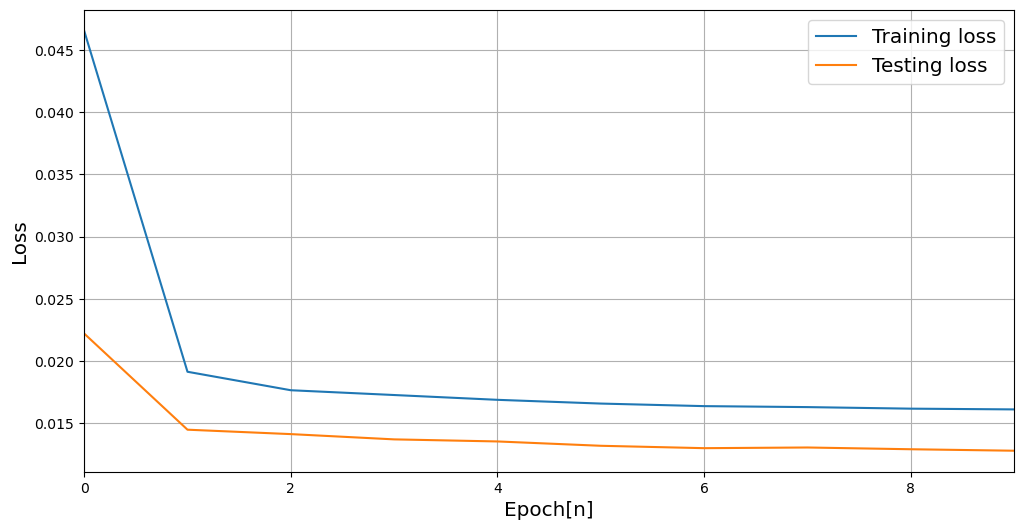

In [35]:
if __name__ == "__main__":
    
        data_loc = '5LSL0-Datasets/Fast_MRI_Knee/' #change the datalocation to something that works for you
        batch_size = 8

        train_loader, test_loader = create_dataloaders(data_loc, batch_size)

        model = ConvNet()

        # train the model
        device = torch.device('cpu')
        n_epochs = 10
        learning_rate = 1e-3
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

        model, train_losses, test_losses = train_model(model, train_loader, test_loader, optimizer, criterion, 
                                                    n_epochs, device, write_to_file=True, save_path='models')
        # move model to cpu
        model = model.cpu()

        plot_loss(train_losses, test_losses, 'images/w3_ex5b.png')

## Exercise 5c

  3%|▎         | 1/31 [00:00<00:05,  5.39it/s]


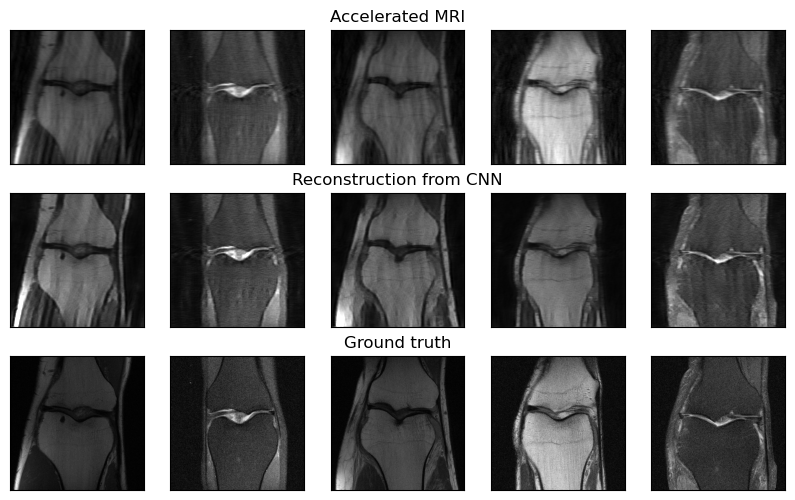

In [36]:
def plot_ex5c(test_acc_mri, test_x_out, test_gt, save_path):

    plt.figure(figsize = (10, 6))
    for i in range(5):
        plt.subplot(3,5,i+1)
        plt.imshow(test_acc_mri[i+1,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if i == 2:
            plt.title('Accelerated MRI')

        plt.subplot(3,5,i+6)
        plt.imshow(test_x_out[i+1,0,:,:],vmax=2,cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if i == 2:
            plt.title('Reconstruction from CNN')

        plt.subplot(3,5,i+11)
        plt.imshow(test_gt[i+1,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if i == 2:
            plt.title('Ground truth')

    plt.savefig(f"{save_path}", dpi=300, bbox_inches='tight')
    plt.show()

for i, (partial_kspace, M, gt) in enumerate(tqdm(test_loader)):
        if i == 1:
            break

# get accelerated MRI image from partial k-space
test_acc_mri = torch.abs(ifft2(partial_kspace))

# unsqueeze to add channel dimension, (N, 320, 320) -> (N, 1, 320, 320)
test_acc_mri = test_acc_mri.unsqueeze(1)
test_gt_unsqueeze = gt.unsqueeze(1)

# get reconstructed image from CNN
test_x_out = model(test_acc_mri)

# detach x_out from GPU
test_x_out = test_x_out.detach().cpu().numpy()

plot_ex5c(test_acc_mri, test_x_out, test_gt_unsqueeze, 'images/w3_ex5c.png')

## Exercise 5d

In [37]:
model.eval()

mse_values = []

train_loader, test_loader = create_dataloaders(data_loc, batch_size)

train_loss = calculate_loss(model, train_loader, criterion, device)
val_loss = calculate_loss(model, test_loader, criterion, device)

testset_loss = (train_loss +val_loss)

print('Mean squared error (mse) on the entire testset: ' + str(testset_loss / (len(train_loader)+len(test_loader))))

100%|██████████| 31/31 [00:13<00:00,  2.24it/s]

Mean squared error (mse) on the entire testset: 0.015195207729935645
